# Инициализация

In [0]:
#@markdown - **Монтирование GoogleDrive** 
from google.colab import drive
drive.mount('GoogleDrive')

In [0]:
# #@markdown - **Размонтирование**
# !fusermount -u GoogleDrive

# Область кодов

In [0]:
#@title Вейвлет нейронные сети { display-mode: "both" }
# Wavelet Neural Network
# В программе реализовано приближение исходных данных с помощью вейвлет-нейронных сетей с одным скрытым слоем
# Можно сравнить с результатами метода регуляризации Тихонова, ИНС
# Вейвлет-нейронные сети явно сходятся быстрее
# conding: utf-8
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# import time

In [0]:
#@markdown - **POLYWOG вейвлет-функции**
def POLYWOG(x, name='POLYWOG1'):
    k1, k2, k3, k4 = tf.sqrt(tf.exp(1.)), 0.7246, 1. / 3, 1.
    c_exp = tf.exp(-.5 * tf.pow(x, 2))
    if name == 'POLYWOG1':
        s = k1 * x * c_exp
    elif name == 'POLYWOG2':
        s = k2 * (tf.pow(x, 3) - 3 * x) * c_exp
    elif name == 'POLYWOG3':
        s = k3 * (tf.pow(x, 4) - 6 * tf.pow(x, 2) + 3) * c_exp
    else: s = k4 * (1 - tf.pow(x, 2)) * c_exp
    return s

## Представление POLYWOG вейвлет-функций

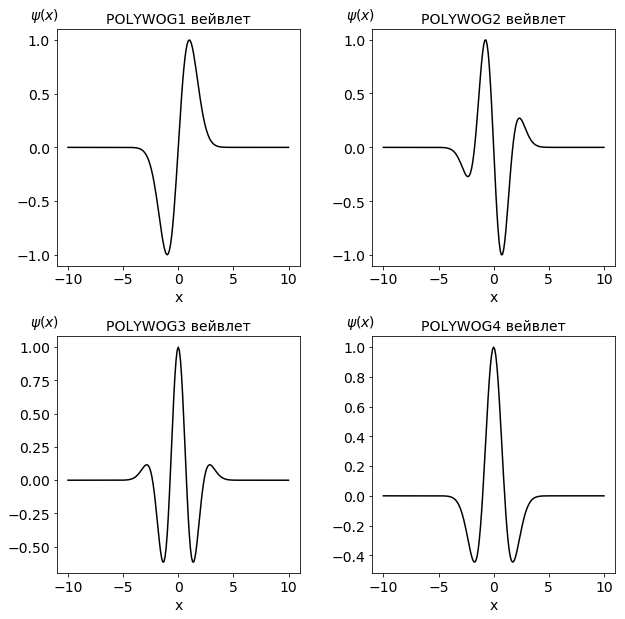

In [2]:
x = np.linspace(-10, 10, 201,endpoint=True)
k1, k2, k3, k4 = np.sqrt(np.e), 0.7246, 1 / 3., 1.
c_exp = np.exp(-.5 * x**2)
polywog1 = k1 * x * c_exp
polywog2 = k2 * (x**3 - 3 * x) * c_exp
polywog3 = k3 * (x**4 - 6 * x**2 + 3) * c_exp
polywog4 = k4 * (1 - x**2) * c_exp
wavelet = [polywog1, polywog2, polywog3, polywog4]

fig, AX = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
# name = ['POLYWOG1 wavelet',u'POLYWOG2 wavelet',u'POLYWOG3 wavelet',
# 		u'POLYWOG4 wavelet',u'POLYWOG5 wavelet']
name = [u'POLYWOG1 вейвлет',u'POLYWOG2 вейвлет',u'POLYWOG3 вейвлет',
		u'POLYWOG4 вейвлет',u'POLYWOG5 вейвлет']
AX = AX.flatten()
for n,ax,f in zip(name, AX, wavelet):
	ax.plot(x, f, 'k')
	ax.set_title(n)
	ax.set_xlabel('x', fontsize=14)
	ax.set_ylabel(r'$\psi (x)$', rotation='horizontal', fontsize=14)
	ax.yaxis.set_label_coords(-.05,1.02)
	ax.tick_params(labelsize=14)
	ax.set_title(n, fontsize=14)

plt.show()

## Блок-схема нейрона ВНС

![](https://github.com/jswanglp/MyML/blob/master/resources/Block_diagram_WNN.PNG?raw=true)

**где，$\psi(x)$ - POLYWOG вейвлет-функции.**

Литература: [Распознавание лиц на основе классификации вейвлет признаков путём вейвлет-нейронных сетей](https://elibrary.ru/item.asp?id=36295551)

In [0]:
#@markdown - **Настройка параметров**
num_epoch = 100 #@param {type: "integer"}
name_wavelet = 'POLYWOG3' #@param {type: "string"} # 4 различных вейвлет-функций
# Предварительная обработка данных образца
data = np.array([[-2.95507616, 10.94533252],
                [-0.44226119, 2.96705822],
                [-2.13294087, 6.57336839],
                [1.84990823, 5.44244467],
                [0.35139795, 2.83533936],
                [-1.77443098, 5.6800407],
                [-1.8657203, 6.34470814],
                [1.61526823, 4.77833358],
                [-2.38043687, 8.51887713],
                [-1.40513866, 4.18262786]])
x = data[:, 0]
y = data[:, 1]
X = x.reshape(-1, 1)
Y = y.reshape(-1, 1)
# Более прогнозируемые данные, чем исходные данные
x_pre = np.linspace(x.min(), x.max(), 30, endpoint=True).reshape(-1, 1)




In [0]:
#@markdown - **Создание graph**
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('Input'):
        x = tf.placeholder(tf.float32, shape=[None, 1], name='x')
        y = tf.placeholder(tf.float32, shape=[None, 1], name='y')
    with tf.name_scope('FC'):
        w_1 = tf.get_variable('w_fc1', shape=[1, 32], initializer=tf.initializers.truncated_normal(stddev=0.1))
        b_1 = tf.get_variable('b_fc1', initializer=tf.constant(0.1, shape=[32]))
        ly = tf.matmul(x, w_1) + b_1
#         t_w = tf.get_variable('t_wavelet', shape=[1, 32], initializer=tf.initializers.truncated_normal(mean=4., stddev=1.))
        t_w = tf.get_variable('t_wavelet', shape=[1, 32], initializer=tf.initializers.random_uniform(minval=2, maxval=15))
        s_w = tf.get_variable('s_wavelet', shape=[1, 32], initializer=tf.initializers.random_normal(stddev=1.))
        ly_h = (ly - s_w) / t_w
        layer_1 = POLYWOG(ly_h, name=name_wavelet)
    with tf.name_scope('Output'):
        w_2 = tf.get_variable('w_fc2', shape=[32, 1], initializer=tf.initializers.truncated_normal(stddev=0.1))
        b_2 = tf.get_variable('b_fc2', initializer=tf.constant(0.1, shape=[1]))
        layer_2 = tf.matmul(layer_1, w_2) + b_2
    var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    with tf.name_scope('Loss'):
        loss = tf.reduce_mean(tf.pow(layer_2 - y, 2))
    with tf.name_scope('Train'):
        train_op = tf.train.AdamOptimizer(learning_rate=3e-1).minimize(loss)

In [0]:
var_list

[<tf.Variable 'w_fc1:0' shape=(1, 32) dtype=float32_ref>,
 <tf.Variable 'b_fc1:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 't_wavelet:0' shape=(1, 32) dtype=float32_ref>,
 <tf.Variable 's_wavelet:0' shape=(1, 32) dtype=float32_ref>,
 <tf.Variable 'w_fc2:0' shape=(32, 1) dtype=float32_ref>,
 <tf.Variable 'b_fc2:0' shape=(1,) dtype=float32_ref>]

In [0]:
#@markdown - **Обучение модели**
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())

#     time_start = time.time()
    print('Activation function: %s wavelet'% name_wavelet)
    for num in range(num_epoch):
        _, ls = sess.run([train_op, loss], feed_dict={x: X, y: Y})
        print_list = [num+1, ls]
        if (num+1) % 10 == 0 or num == 0:
            print('Epoch {0[0]}, loss: {0[1]:.4f}.'.format(print_list))
    t_wavelet, s_wavelet, layer_1, layer_h = sess.run([t_w, s_w, ly, ly_h], feed_dict={x: X})
    # time_start = time.time()
    y_pre = sess.run(layer_2, feed_dict={x: x_pre})
    sess.close()
#     time_end = time.time()
#     t = time_end - time_start
#     print('Running time is: %.4f s.' % t)

Activation function: POLYWOG3 wavelet
Epoch 1, loss: 44.8067.
Epoch 10, loss: 3.2883.
Epoch 20, loss: 0.7615.
Epoch 30, loss: 0.0990.
Epoch 40, loss: 0.0636.
Epoch 50, loss: 0.0674.
Epoch 60, loss: 0.0677.
Epoch 70, loss: 0.0584.
Epoch 80, loss: 0.0545.
Epoch 90, loss: 0.0544.
Epoch 100, loss: 0.0542.


In [0]:
#@markdown - **Коэффициент сжатия для каждого нейрона**
t_wavelet

array([[ 0.5944622 , 10.249353  , 10.267239  , 13.048834  , 15.151084  ,
        15.409376  ,  9.080558  ,  7.055534  , 10.094398  ,  9.931294  ,
        13.628946  , 13.54618   ,  7.6268306 , 13.865662  , 15.291048  ,
        13.340068  ,  9.609813  ,  6.1534476 ,  3.2031226 ,  4.063137  ,
        17.334763  ,  4.9708943 , 14.081547  , 14.264666  ,  5.066471  ,
         0.5245679 , 15.117103  , -0.17910613,  2.5228536 ,  4.9027553 ,
         5.9350786 , 13.836817  ]], dtype=float32)

In [0]:
#@markdown - **Коэффициент смещения каждого нейрона**
s_wavelet

array([[ 3.9312744 , -0.9398056 ,  3.71997   ,  1.7088618 , -0.28617758,
         2.0550287 , -5.139775  ,  1.7258714 ,  4.2225904 , -1.7311946 ,
        -2.779069  , -2.262794  , -3.9746885 , -2.3270078 ,  1.5303732 ,
        -0.40134147, -2.880719  , -4.9544525 ,  6.0667534 , -3.8637335 ,
        -0.4073877 ,  1.2404523 ,  1.5876559 , -0.42235678,  4.4432893 ,
         5.067055  , -1.732875  ,  3.6961522 , -3.2819932 , -3.4250183 ,
         4.938069  ,  2.8803453 ]], dtype=float32)

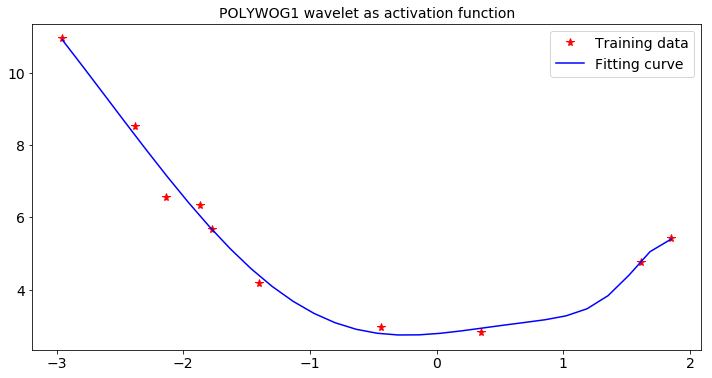

In [0]:
#@markdown - **Функция активации - POLYWOG1**
data_pre = np.c_[x_pre, y_pre]
DATA = [data, data_pre]
NAME = ['Training data', 'Fitting curve']
STYLE = ['*r', 'b']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
for dat, name, style in zip(DATA, NAME, STYLE):
    ax.plot(dat[:, 0], dat[:, 1], style, markersize=8, label=name)
    ax.legend(loc='upper right', fontsize=14)
    ax.tick_params(labelsize=14)
plt.title('POLYWOG1 wavelet as activation function', fontsize=14)
plt.show()

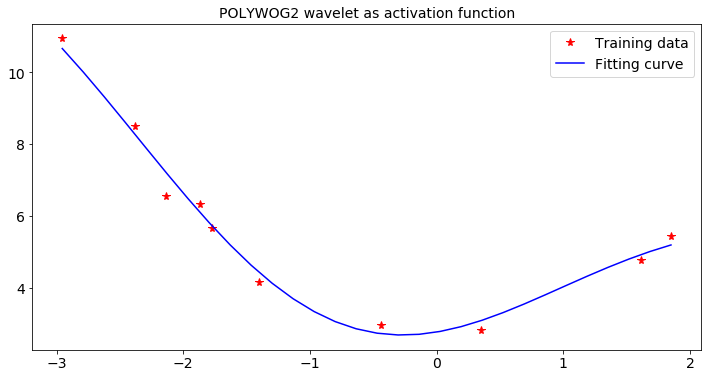

In [0]:
#@markdown - **Функция активации - POLYWOG2**
data_pre = np.c_[x_pre, y_pre]
DATA = [data, data_pre]
NAME = ['Training data', 'Fitting curve']
STYLE = ['*r', 'b']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
for dat, name, style in zip(DATA, NAME, STYLE):
    ax.plot(dat[:, 0], dat[:, 1], style, markersize=8, label=name)
    ax.legend(loc='upper right', fontsize=14)
    ax.tick_params(labelsize=14)
plt.title('POLYWOG2 wavelet as activation function', fontsize=14)
plt.show()

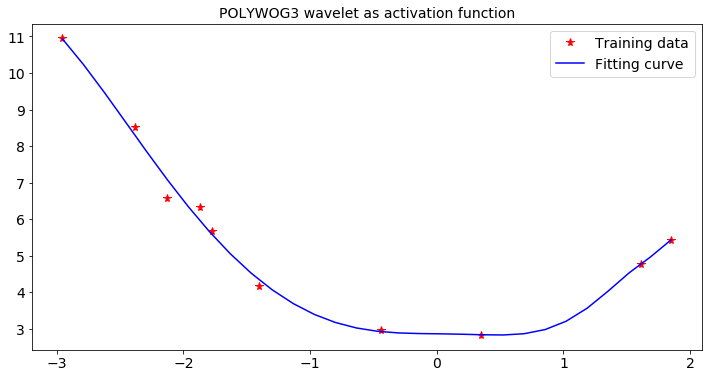

In [0]:
#@markdown - **Функция активации - POLYWOG3**
data_pre = np.c_[x_pre, y_pre]
DATA = [data, data_pre]
NAME = ['Training data', 'Fitting curve']
STYLE = ['*r', 'b']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
for dat, name, style in zip(DATA, NAME, STYLE):
    ax.plot(dat[:, 0], dat[:, 1], style, markersize=8, label=name)
    ax.legend(loc='upper right', fontsize=14)
    ax.tick_params(labelsize=14)
plt.title('POLYWOG3 wavelet as activation function', fontsize=14)
plt.show()

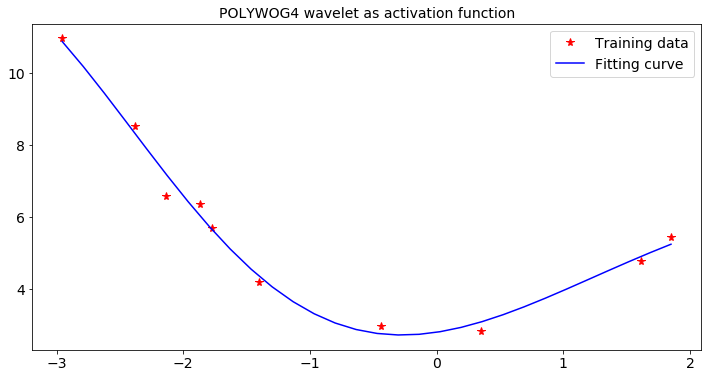

In [0]:
#@markdown - **Функция активации - POLYWOG4**
data_pre = np.c_[x_pre, y_pre]
DATA = [data, data_pre]
NAME = ['Training data', 'Fitting curve']
STYLE = ['*r', 'b']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
for dat, name, style in zip(DATA, NAME, STYLE):
    ax.plot(dat[:, 0], dat[:, 1], style, markersize=8, label=name)
    ax.legend(loc='upper right', fontsize=14)
    ax.tick_params(labelsize=14)
plt.title('POLYWOG4 wavelet as activation function', fontsize=14)
plt.show()